In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import dynchro

In [3]:
# autorelad
%load_ext autoreload
%autoreload 2

# 1. Preprocess data 

In [4]:
rep1_mono = ad.read_h5ad("../3_large_scale/data/rep1_mono_hvg.h5ad")
rep3_mono = ad.read_h5ad("../3_large_scale/data/rep3_mono_hvg.h5ad")
rep1_mono, rep3_mono

(AnnData object with n_obs × n_vars = 3721 × 2082
     obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'cell_type', 'milestones', 'pseudotime', 'Mono'
     uns: 'cell_type_colors', 'cluster_colors', 'clusters_colors', 'ct_colors', 'id', 'lineage_labels', 'palantir_branch_probs_cell_types', 'pseudocells', 'pseudocells_100_Mono_pseudotime', 'pseudocells_100_Mono_pseudotime_index', 'pseudocells_100_Mono_pseudotime_values'
     obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs', 'tsne'
     varm: 'pseudocells_100_Mono',
 AnnData object with n_obs × n_vars = 6934 × 2066
     obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential', 'cell_type', 'milestones', 'pseudotime', 'Mono'
     uns: 'cell_type_colors', 'cluster_colors', 'clusters_colors', 'ct_colors', 'id', 'lineage_labels', 'palantir_branch_probs_cell_types', 'pseudocells', 'pseudocells_100_Mono_pseudotime', 'pseudocells_100_Mono_pseudotime_index', 'pseudocells_100_Mono_pseudotime_values'
     o

In [5]:
rep1_mono = rep1_mono[np.argsort(rep1_mono.obs["pseudotime"]), :]
rep3_mono = rep3_mono[np.argsort(rep3_mono.obs["pseudotime"]), :]

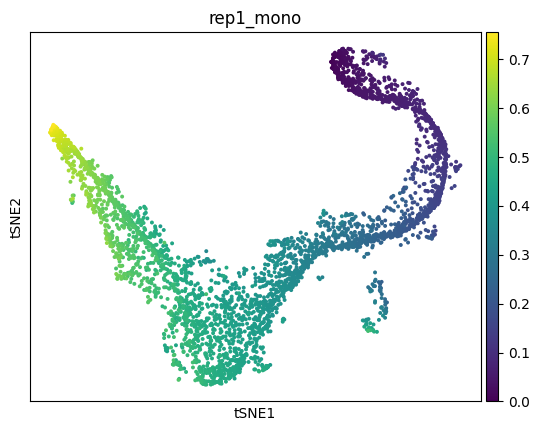

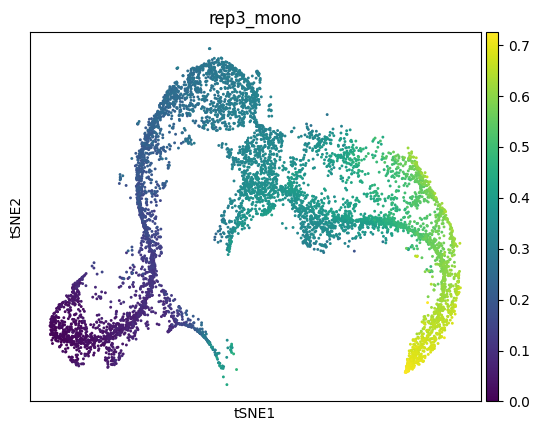

In [6]:
sc.pl.tsne(rep1_mono, color="pseudotime", title="rep1_mono")
sc.pl.tsne(rep3_mono, color="pseudotime", title="rep3_mono")

# 2. Generate pseudocells

In [7]:
# Generate pseudocells
def calculate_pseudocells(adata, amount: int):
    trunc_anndata = adata
    pseudocell_pseudotimes = interpolate_pseudocells(trunc_anndata, amount)
    trunc_anndata, pseudocells = smooth_pseudocells(trunc_anndata, pseudocell_pseudotimes, amount)

    pseudocell_names = [f"pseudocell_{i}" for i in range(amount)]
    pseudocell_pseudotimes = {k: v for k, v in zip(pseudocell_names, pseudocell_pseudotimes)}

    # Save information into anndata
    adata.varm[f"pseudocells_{amount}"] = pseudocells.T
    adata.uns[f"pseudocells_{amount}_pseudotime"] = pd.Series(pseudocell_pseudotimes)
    if "pseudocells" not in adata.uns:
        adata.uns["pseudocells"] = []
    adata.uns["pseudocells"] += [f"pseudocells_{amount}"]
    return adata

def calc_pc(adata, amount, obsm_key=None):
    interpolated = interpolate_uniform(adata, amount)
    adata, pseudocells, transition_matrix = smooth_pseudocells(adata, interpolated, amount, obsm_key)
    pseudocell_names = [f"pseudocell_{i}" for i in range(amount)]
    pseudocell_pseudotimes = {k: v for k, v in zip(pseudocell_names, interpolated)}

    return adata, pseudocells, pseudocell_pseudotimes, transition_matrix


def interpolate_pseudocells(adata, amount: int):
    # interpolate pseudotime based on the distribution of real cells in the pseudotime
    return np.percentile(sorted(adata.obs.pseudotime.values), np.linspace(0.0, 100, amount))

def interpolate_uniform(adata, amount: int):
    # interpolate pseudotime uniformly
    min_pseudotime = adata.obs.pseudotime.min()
    max_pseudotime = adata.obs.pseudotime.max()
    return np.linspace(min_pseudotime, max_pseudotime, amount)


def smooth_pseudocells(adata, pseudocell_pseudotimes, amount: int, obsm_key=None) -> np.ndarray:
    distances = calculate_pseudotime_distance(pseudocell_pseudotimes, sorted(adata.obs.pseudotime.values))
    adata.uns[f"transition_matrix_{amount}"] = np.array(
        [get_gaussian_transition_matrix(distances[i,], adata.X) for i in range(distances.shape[0])]
    )
    features = adata.X
    if obsm_key is not None:
        features = adata.obsm[obsm_key]
    return adata, np.array([apply_gaussian_kernel(distances[i,], features) for i in range(distances.shape[0])]), adata.uns[f"transition_matrix_{amount}"]

def calculate_pseudotime_distance(pseudocell_pseudotimes, trajectory_pseudotime: np.ndarray) -> np.ndarray:
    distances = []
    for cell in pseudocell_pseudotimes:
        distance = trajectory_pseudotime - cell
        distances.append(distance)
    return np.array(distances)

def apply_gaussian_kernel(x, counts):
    d = get_gaussian_transition_matrix(x, counts)
    
    # d = np.exp(-1 * (x**2) / (2**2))

    # FOR VISUALISATION PURPOSES
    # import matplotlib.pyplot as plt

    # plt.plot(x, color = "red")
    # plt.plot(d, color = "blue")
    # plt.figure()
    # plt.show()

    # d = d / sum(d)
    # plt.plot(d, color = "green")

    # plt.show()

    # @ = matrix multiplication (is transposition necessary or could the arguments be switched?)
    return counts.T @ d


def get_gaussian_transition_matrix(x, counts):
    d = np.exp(-1 * (x**2) / (0.0025**2))
    return d / sum(d)


In [8]:
rep1_mono_, rep1_mono_pseudocells, rep1_mono_pseudotimes, rep1_trans = calc_pc(rep1_mono, 75)
rep3_mono_, rep3_mono_pseudocells, rep3_mono_pseudotimes, rep3_trans = calc_pc(rep3_mono, 150)

/tmp/ipykernel_207633/3412793216.py:40: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"transition_matrix_{amount}"] = np.array(
/tmp/ipykernel_207633/3412793216.py:40: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[f"transition_matrix_{amount}"] = np.array(


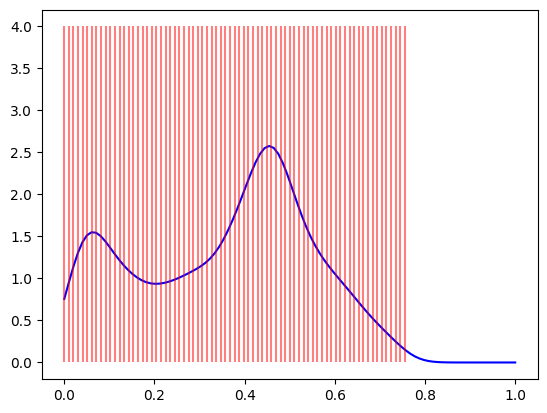

In [9]:
import scipy as sp
pseudotimes_kde_orig = sp.stats.gaussian_kde(rep1_mono.obs["pseudotime"])
x_values = np.linspace(0, 1, 100)
y_values = pseudotimes_kde_orig(x_values)
plt.plot(x_values, y_values, color = "blue")
plt.vlines(rep1_mono_pseudotimes.values(), 0, 4, color = "red", alpha=0.5)

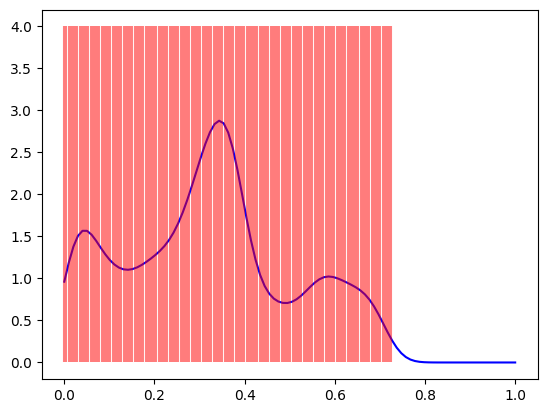

In [10]:
pseudotimes_kde_orig_3 = sp.stats.gaussian_kde(rep3_mono.obs["pseudotime"])
x_values3 = np.linspace(0, 1, 100)
y_values3 = pseudotimes_kde_orig_3(x_values3)
plt.plot(x_values3, y_values3, color = "blue")
plt.vlines(rep3_mono_pseudotimes.values(), 0, 4, color = "red", alpha=0.5)

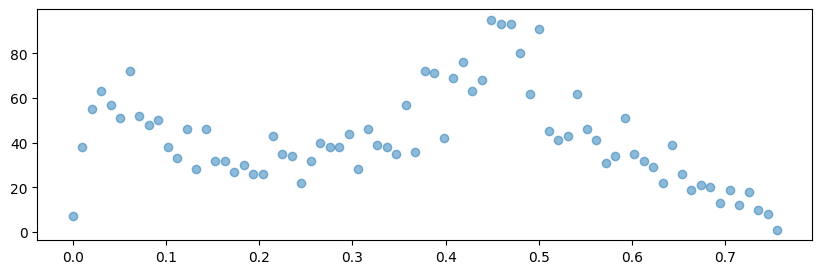

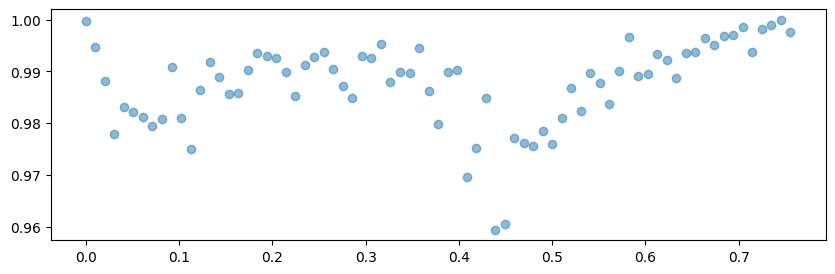

In [10]:
# get all contributions
contributions = []
contributing_cells = []
for i in range(rep1_trans.shape[0]):
    contributing_cells_part = rep1_trans[i,:] >= 0.002
    contributing_cells.append(contributing_cells_part)
    contribution = rep1_trans[i,:][rep1_trans[i, :] >= 0.002]
    contributions.append((sum(contribution), len(contribution)))
    # contributing_cells.extend([i] * len(contribution))

# plot amount covered and number of cells contributing
plt.figure(figsize=(10, 3))
plt.scatter(rep1_mono_pseudotimes.values(), [x[1] for x in contributions], alpha=0.5)
plt.show()
plt.figure(figsize=(10, 3))
plt.scatter(rep1_mono_pseudotimes.values(), [x[0] for x in contributions], alpha=0.5)

# 3. DTW on pseudocells

In [11]:
d3 = ad.AnnData(X = rep1_mono_pseudocells, var = rep1_mono.var, obs = pd.DataFrame({"pseudotime": rep1_mono_pseudotimes}))
d4 = ad.AnnData(X = rep3_mono_pseudocells, var = rep3_mono.var, obs = pd.DataFrame({"pseudotime": rep3_mono_pseudotimes}))
common_vars = list(set.intersection(*(set(trajectory.var_names) for trajectory in [d3, d4])))
# select common vars
d3 = d3[:, common_vars]
d4 = d4[:, common_vars]
d3, d4

(View of AnnData object with n_obs × n_vars = 75 × 2048
     obs: 'pseudotime',
 View of AnnData object with n_obs × n_vars = 150 × 2048
     obs: 'pseudotime')

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['dtw_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:120: ImplicitModificationWarning: Setting element `.obsm['dtw_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


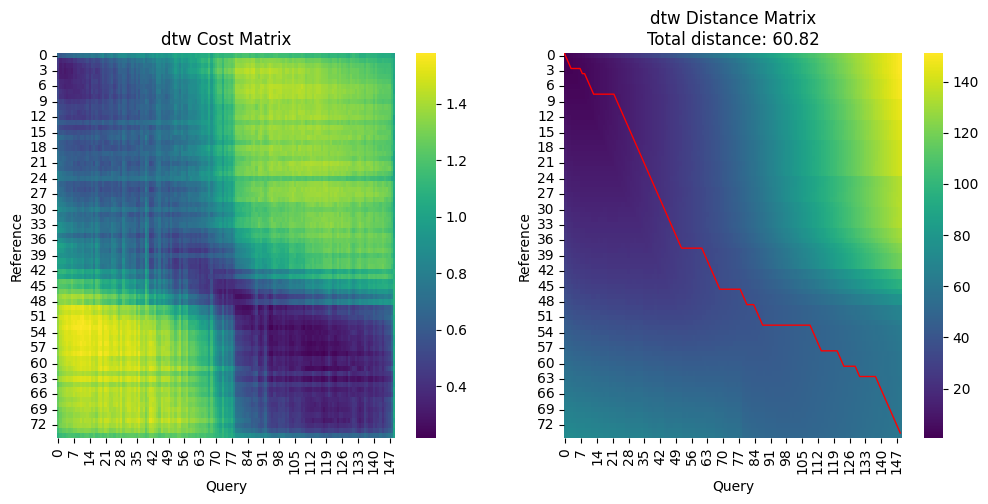

In [12]:
d3, d4 = dynchro.tl.dtw(d3, d4, distance= "correlation")
d3, d4 = dynchro.tl.traceback(d3, d4, diag_mult=1.0)

d4 = dynchro.tl.warp_pseudotime(d3, d4)
d3 = dynchro.tl.warp_pseudotime(d4, d3)

dynchro.pl.plot_dtw_matrices(d3, d4)

# 4. DTW on actual cells

/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:116: ImplicitModificationWarning: Setting element `.obsm['dtw_cost']` of view, initializing view as actual.
  reference.obsm[f"{dtw_key}_cost"] = cost
/home/louise/Work/dynchro/src/dynchro/tl/dtw.py:120: ImplicitModificationWarning: Setting element `.obsm['dtw_cost']` of view, initializing view as actual.
  query.obsm[f"{dtw_key}_cost"] = cost.T


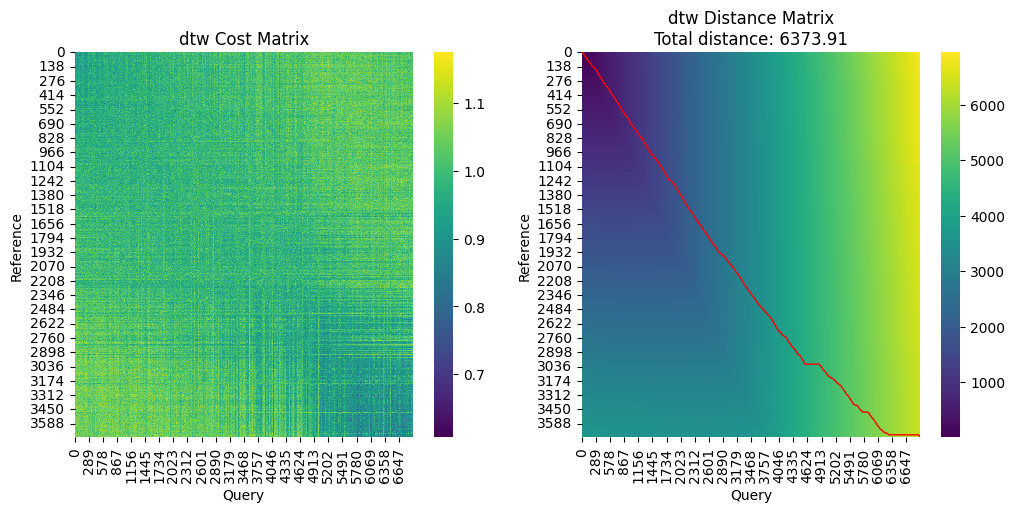

In [13]:
common_vars = list(set.intersection(*(set(trajectory.var_names) for trajectory in [rep1_mono, rep3_mono])))
# select common vars
rep1_mono = rep1_mono[:, common_vars]
rep3_mono = rep3_mono[:, common_vars]


d1, d2 = rep1_mono, rep3_mono

d1, d2 = dynchro.tl.dtw(d1, d2, distance= "correlation")
d1, d2 = dynchro.tl.traceback(d1, d2, diag_mult=1.0)

d2 = dynchro.tl.warp_pseudotime(d1, d2)
d1 = dynchro.tl.warp_pseudotime(d2, d1)

dynchro.pl.plot_dtw_matrices(d1, d2)


# 5. Compare warpings

In [14]:
def map_back(transition_matrix, pseudocell_dataset):
    tresh = 0.001
    mapped_warped_pseudotimes = []
    for i in range(transition_matrix.shape[1]):
        res = transition_matrix[:, i] / sum(transition_matrix[:, i])

        warped_pseudotimes = pseudocell_dataset.obs[res > tresh].dtw_warped_pseudotime.values
        contribution_amounts = res[res > tresh]

        result = np.average(warped_pseudotimes, weights=contribution_amounts)
        mapped_warped_pseudotimes.append(result)

    return mapped_warped_pseudotimes

In [15]:
mapped_warped_1 = map_back(transition_matrix=rep3_trans, pseudocell_dataset=d4)
mapped_warped_2 = map_back(transition_matrix=rep1_trans, pseudocell_dataset=d3)

d2.obs["mapped_warped_pseudotime"] = mapped_warped_1
d1.obs["mapped_warped_pseudotime"] = mapped_warped_2

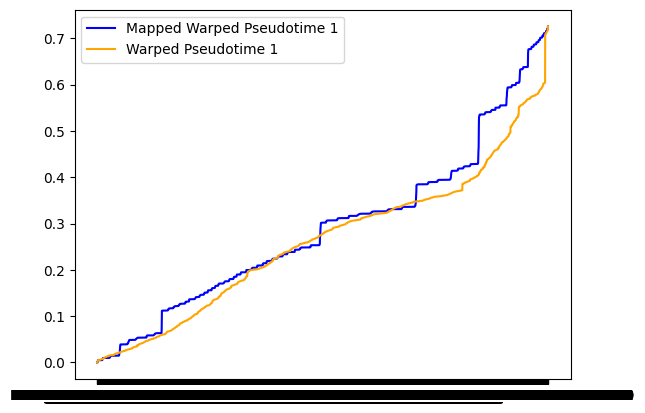

In [16]:
plt.plot(d1.obs["mapped_warped_pseudotime"], label="Mapped Warped Pseudotime 1", color='blue')
plt.plot(d1.obs["dtw_warped_pseudotime"], label="Warped Pseudotime 1", color='orange')

plt.legend()

# 6. Figure

In [17]:
colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)

import numpy as np

def get_colors(colors, labels, color_map=None):
    if color_map is None:
        color_map = {label: colors[i] for i, label in enumerate(np.unique(labels))}
    translated_colors = np.array([color_map[c] for c in labels])

    handles, labels = get_color_legend(color_map)

    return translated_colors, handles, labels

def get_color_legend(color_map):
    handles = [
        plt.Line2D(
                [0], [0], marker='o', markerfacecolor=c, color = "k", 
                markersize = 7.5, lw = 0
            ) for c in color_map.values()
        ]
    labels = list(color_map.keys())
    return handles, labels

def plot_celltypes(adata, ax, legendax = None, flipy = False, colormap = None):
    xs = adata.obsm['X_tsne'][:, 0]
    ys = adata.obsm['X_tsne'][:, 1]

    if flipy:
        ys = -adata.obsm['X_tsne'][:, 1]
    labels = adata.obs['cell_type'].values

    translated_colors, handles, labels = get_colors(colors, labels, color_map=colormap)

    ax.scatter(xs, ys, c=translated_colors,  s=50, edgecolors = 'k')

    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    # ax.set_xlabel("Flat tree plot", fontdict={'fontsize': 8})
    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.set_label_coords(0.15, 0.1)
    ax.set_ylabel("")

    x0 = ax.get_xlim()[0]
    y0 = ax.get_ylim()[0]

    ax.annotate("", xy=(-0.01, 0.35), xytext=(-0.01, 0.04), xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle="->", color='k'))

    # ax.arrow(x0, y0, 3, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
    ax.set_xlabel("UMAP 1", fontsize=8)
    ax.xaxis.set_label_coords(0.15, -0.04)

    ax.annotate("", xy=(0.3, -0.01), xytext=(0.04, -0.01), xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(arrowstyle="->", color='k'))
    # ax.arrow(x0, y0, 0, 3, head_width=0.5, head_length=0.5, fc='k', ec='k')
    ax.set_ylabel("UMAP 2", fontsize=8)
    ax.yaxis.set_label_coords(-0.04, 0.18)

    if legendax is not None:
        legendax.axis('off')
        legendax.legend(handles=handles, labels=labels, title="", loc='center', frameon=False, fontsize="x-small", title_fontsize="small")

    return ax

/tmp/ipykernel_207633/3364798540.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("Set2").colors + (plt.cm.get_cmap("Set3").colors[9],)


In [18]:
def flatten(values : list) -> list:
    """
    Flatten a list of lists into a single list.
    """
    flat_list = []

    for sublist in values:
        if isinstance(sublist, list):
            # If the item is a list, extend the result with its contents
            flat_list.extend(sublist)
        else:
            # If the item is not a list, append it directly if it is not None
            if sublist is not None:
                flat_list.append(sublist)

    return flat_list


def plot_matrix(matrix, axes, xticks, yticks, pathx, pathy):
    im = axes[0].imshow(matrix, cmap='viridis', aspect='auto')
    # axes.set_title(title)
    axes[0].set_xticks(xticks)
    axes[0].set_yticks(yticks)

    # plot colorbar
    fig.colorbar(im, ax=axes[0], pad=0.1)
    # plt.colorbar(im, ax=axes[1], fraction=0.75, shrink=0.75)
    path1 = flatten(pathx) #flatten(reference.obs[f"{dtw_key}_path"])
    path2 = flatten(pathy) #flatten(query.obs[f"{dtw_key}_path"])

    axes[0].plot(path1, path2, color='red', linewidth=1)

In [19]:
def plot_comparisons(data, ax, square = None):
    xs = data.obs["pseudotime"].values
    ys1 = data.obs["mapped_warped_pseudotime"].values
    ys2 = data.obs["dtw_warped_pseudotime"].values

    if square:
        ax.axvspan(square[0], square[1], color=colors[7], alpha=0.5)        

    ax.plot(xs, ys2, label="Original", color=colors[0])
    ax.plot(xs, ys1, label="Pseudocells", color=colors[1])
    ax.set_xlabel("Pseudotime", fontsize=8)
    ax.set_ylabel("Warped Pseudotime", fontsize=8)
    # ax.legend()


In [22]:
def plot_pseudocells(data, ax, pseudocells):
    pseudotimes_kde_orig = sp.stats.gaussian_kde(data.obs["pseudotime"])
    x_values = np.linspace(0, 1, 100)
    y_values = pseudotimes_kde_orig(x_values)
    
    ax.vlines(pseudocells, 0, 4, color = colors[1], alpha=1, lw = 0.5)
    ax.plot(x_values, y_values, color = colors[0])


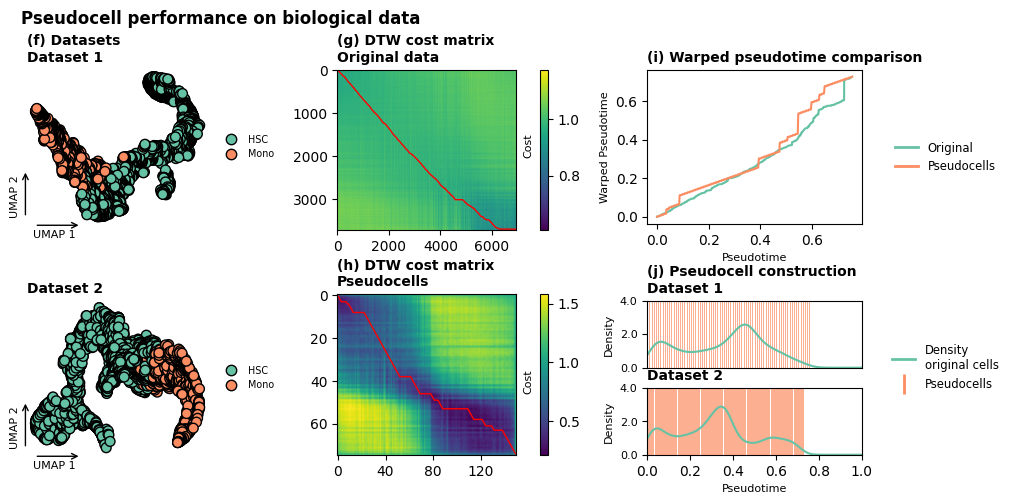

In [25]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("Pseudocell performance on biological data", fontsize=12, fontweight='bold', x=0.12, y=1, horizontalalignment='left')
gs_outer = fig.add_gridspec(2, 4, width_ratios = [1,1,0.9, 0.1], height_ratios = [1,1], hspace=0.5, wspace = 0.4)

gsa = gs_outer[0, 0].subgridspec(1, 2, width_ratios=[1, 0.2])
axa1, axa2 = gsa.subplots()
gsb = gs_outer[1, 0].subgridspec(1, 2, width_ratios=[1, 0.2])
axb1, axb2 = gsb.subplots()
# (axa, axb), (axc, axd), (axe, axf) = gs_outer.subplots()

plot_celltypes(d1, axa1, legendax=axa2)
plot_celltypes(d2, axb1, legendax=axb2)
axa1.set_title("(f) Datasets\nDataset 1", fontsize=10, fontweight='bold', loc='left')
axb1.set_title("Dataset 2", fontsize=10, fontweight='bold', loc='left')

axc, axd = gs_outer[:, 1].subgridspec(2, 1, hspace=0.4).subplots()

# axc = gs_outer[0, 1].subgridspec(1, 1).subplots()
# axd = gs_outer[1, 1].subgridspec(1, 1).subplots()

yticks0 = [0, 1000, 2000, 3000, 4000, 5000]
xticks0 = [0, 2000, 4000, 6000]

yticks1 = [0, 20, 40, 60, 80, 100]
xticks1 = [0, 40, 80, 120, 160]

plot_matrix(d1.obsm['dtw_cost'], (axc,), xticks=xticks0, yticks=yticks0, pathx=d1.obs["dtw_path"], pathy=d2.obs["dtw_path"])
axc.text(7400, 2000, "Cost", rotation=90, horizontalalignment='center', fontsize=8)
plot_matrix(d3.obsm['dtw_cost'], (axd,), xticks=xticks1, yticks=yticks1, pathx=d3.obs["dtw_path"], pathy=d4.obs["dtw_path"])
axd.text(160, 40, "Cost", rotation=90, horizontalalignment='center', verticalalignment='center', fontsize=8)

axc.set_title("(g) DTW cost matrix\nOriginal data", fontsize=10, fontweight='bold', loc='left')
axd.set_title("(h) DTW cost matrix\nPseudocells", fontsize=10, fontweight='bold', loc='left')

axe = gs_outer[0, 2].subgridspec(1, 1).subplots()
plot_comparisons(d1, ax=axe)
# plot_comparisons(d2, ax=axe[1])
axe.set_title("(i) Warped pseudotime comparison", fontsize=10, fontweight='bold', loc='left')
# axe.margins(0, 0.05)
# axe.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
# axe.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
# axe.set_xticklabels([0.0, 0.25, 0.5, 0.75, 1.0], fontdict={'fontsize': 8})
# axe.set_yticklabels([0.0, 0.25, 0.5, 0.75, 1.0], fontdict={'fontsize': 8})

axf, axg = gs_outer[1, 2].subgridspec(2, 1, hspace=0.3).subplots()

plot_pseudocells(rep1_mono, axf, rep1_mono_pseudotimes.values())
plot_pseudocells(rep3_mono, axg, rep3_mono_pseudotimes.values())

axf.set_xticklabels([])
axf.margins(0, 0)

axf.set_yticks([0.0, 2.0, 4.0])
axg.set_yticks([0.0, 2.0,4.0])
axf.set_yticklabels([0.0, 2.0, 4.0], fontdict={'fontsize': 8})
axg.set_yticklabels([0.0, 2.0, 4.0], fontdict={'fontsize': 8})
axf.set_xticks([])
# axf.set_xticklabels([0.0, 0.25, 0.5, 0.75, 1.0], fontdict={'fontsize': 8})

# axf.set_xticklabels(axf.get_xticklabels(), fontdict={'fontsize': 8})
# axg.set_yticklabels(axg.get_yticklabels(), fontdict={'fontsize': 8})
# axg.set_yticklabels(axg.get_yticklabels(), fontdict={'fontsize': 8})
axg.margins(0, 0)

axg.set_xlabel("Pseudotime", fontsize=8)
axf.set_ylabel("Density", fontsize=8)
axg.set_ylabel("Density", fontsize=8)

axf.set_title("(j) Pseudocell construction\nDataset 1", fontsize=10, fontweight='bold', loc='left')
axg.set_title("Dataset 2", fontsize=10, fontweight='bold', loc='left')

axh, axi = gs_outer[:, 3].subgridspec(2, 1).subplots()
handles = [
    plt.Line2D([0], [0], color=colors[0], lw=2),
    plt.Line2D([0], [0], color=colors[1], lw=2)
    # plt.Rectangle((0,0),1,1, color=colors[7], alpha=0.5)
]
labels = ["Original", "Pseudocells"]
axh.axis('off')
axh.legend(handles=handles, labels=labels, title="", loc='center', frameon=False, fontsize="small")

handles = [
    plt.Line2D([0], [0], color=colors[0], lw=2),
    plt.Line2D([0], [0], marker = "|", color=colors[1], lw=0, markersize=15, markeredgewidth=2)
]
labels = ["Density\noriginal cells", "Pseudocells"]
axi.axis('off')
axi.legend(handles=handles, labels=labels, title="", loc='center', frameon=False, fontsize="small")

plt.savefig("figure_4_palantir_data.pdf", bbox_inches='tight', dpi=300)
plt.savefig("figure_4_palantir_data.png", bbox_inches='tight', dpi=300)


In [64]:
d1.obs

,clusters,palantir_pseudotime,palantir_diff_potential,cell_type,milestones,pseudotime,Mono,dtw_path,dtw_cells_path,dtw_warped_pseudotime,mapped_warped_pseudotime
index,,,,,,,,,,,
Run5_205922701598003,0,0.000000,1.421836,HSC,0,0.000000,True,[0],[Run4_165860338686773],0.000000,0.000000
Run4_170343460457182,0,0.001860,1.421818,HSC,0,0.001860,True,[1],[Run3_232438996323742],0.000217,0.000000
Run5_165851837091182,0,0.002412,1.421818,HSC,0,0.002412,True,"[2, 3]","[Run2_155842596255526, Run4_166332067605726]",0.000886,0.000000
Run4_226265786674531,0,0.003325,1.421876,HSC,0,0.003325,True,[4],[Run2_126681615817140],0.001319,0.000000
Run5_236170027060141,0,0.003534,1.421920,HSC,0,0.003534,True,"[5, 6, 7, 8, 9, 10]","[Run1_166469238999901, Run2_165302215294387, R...",0.001361,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
Run5_231822803233142,3,0.746279,0.250693,Mono,3,0.746279,True,[6928],[Run4_227930488559411],0.716432,0.720676
Run4_120726943295348,3,0.746549,0.248381,Mono,3,0.746549,True,[6929],[Run1_227973453756700],0.718107,0.720676
Run4_164753398685099,3,0.748845,0.260523,Mono,3,0.748845,True,"[6930, 6931]","[Run2_232330307753892, Run2_195426069367093]",0.719501,0.720795
